# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import datetime
import sys
import aiutils.aiutils as ai
import aiutils.aiutils_keras as ker
import aiutils.features_manager as feat
import aiutils.labels_manager as lab
import aiutils.ai_backtester as bt
import aiutils.preprocessing as pr
import talib as ta
import pandas_ta as ta
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, PReLU, ELU, ThresholdedReLU, Conv1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Magic commands
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
pd.options.display.width=None

# Avoid scientific notation when printing numpy arrays in most cases
np.set_printoptions(suppress=True)


# Chargement des données

In [2]:
filename = r'.\EURUSD_1H_UTC.csv'
df = ai.read_timeseries_from_csv(filename=filename,closedatetimeref=False,totimescale='1H',fromtimezone='UTC',totimezone='Europe/Paris')
pair = 'EURUSD'
#Calcul des différentes features
def create_features(data, adx = True,use_bol = True,macd = True,diff_ll = True,rol_means = True,kama = True,ao = True,aron=True,rsi= True,hull=True, stoch=True, ema=True): 
        
    for index in range(1,4):
        data = feat.add_ohlc_features(data, f'C{index}O{index}')
        data = feat.add_ohlc_features(data, f'C{index}O{index-1}')
        
        
    feat.add_ohlc_features(data, 'OH1')
    feat.add_ohlc_features(data, 'OL1')

    if rsi:
        data.ta.rsi(append=True)
        data[f'RSI_{14}']=data[f'RSI_{14}'].shift(1)

    if diff_ll:
        data = feat.add_hh_ll(data,periods=3,shift=1,drop_na=False)
        data = feat.add_hh_ll(data,periods=5,shift=1,drop_na=False)
        data = feat.add_hh_ll(data,periods=10,shift=1,drop_na=False)
        data = feat.add_hh_ll(data,periods=15,shift=1,drop_na=False)
        data['LL5LL3'] = 10000*(data['LL5'] - data['LL3'])
        data['LL10LL3'] = 10000*(data['LL10'] - data['LL3'])
        data['LL15LL3'] = 10000*(data['LL15'] - data['LL3'])
        data['HH5HH3'] = 10000*(data['HH5'] - data['HH3'])
        data['HH10HH3'] = 10000*(data['HH10'] - data['HH3'])
        data['HH15HH3'] = 10000*(data['HH15'] - data['HH3'])
        data["OLL3"] = 10000*(data["open"]-data["LL3"])
        data["OLL5"] = 10000*(data["open"]-data["LL5"])
        data["OLL10"] = 10000*(data["open"]-data["LL10"])
        data["OLL15"] = 10000*(data["open"]-data["LL15"])
        data["OHH3"] = 10000*(data["open"]-data["HH3"])
        data["OHH5"] = 10000*(data["open"]-data["HH5"])
        data["OHH10"] = 10000*(data["open"]-data["HH10"])
        data["OHH15"] = 10000*(data["open"]-data["HH15"])

    if use_bol:
        data['MA20'] = data['close'].shift(1).rolling(window=20).mean() 
        data['MA20dSTD'] = data['close'].shift(1).rolling(window=20).std() 
        data['Bollinger_Upper'] = data['MA20'] + (data['MA20dSTD'] * 2)
        data['Bollinger_Lower'] = data['MA20'] - (data['MA20dSTD'] * 2)


        data['U_minus_L'] = data['Bollinger_Upper'] - data['Bollinger_Lower']
        data['pullback'] = data['close'].shift(1) - data['Bollinger_Upper'].shift(1)
        data['throwback'] = data['close'].shift(1) - data['Bollinger_Lower'].shift(1)

    if rol_means:
        data['CO'] = data['close'] - data['open']
        data['rmCO(3)'] = data['CO'].shift(1).rolling(window=3).mean() 
        data['rmCO(4)'] = data['CO'].shift(1).rolling(window=4).mean() 
        data['rmCO(5)'] = data['CO'].shift(1).rolling(window=5).mean() 
        data['rmCO(6)'] = data['CO'].shift(1).rolling(window=6).mean() 

    if adx:
        for i in [5,7,10]:
            data.ta.adx(i,append=True)
            data[f'ADX_{i}'] = data[f'ADX_{i}'].shift(1)
            data[f'DMP_{i}'] = data[f'DMP_{i}'].shift(1)
            data[f'DMN_{i}'] = data[f'DMN_{i}'].shift(1)

    if ao :
        data.ta.ao(3,6,append=True)
        data[f'AO_{3}_{6}'] = data[f'AO_{3}_{6}'].shift(1)

    if kama:
        data.ta.kama(length=10,slow=30,append=True)
        data[f'OKAMA_{10}_{2}_{30}'] = data['open'] - data[f'KAMA_{10}_{2}_{30}'].shift(1)

    if macd :
        fast_macd=12
        slow_macd=26
        signal_macd =9
        data.ta.macd(fast=fast_macd,slow=slow_macd,signal=signal_macd,append=True)
        data[f'MACD_{fast_macd}_{slow_macd}_{signal_macd}'] = data[f'MACD_{fast_macd}_{slow_macd}_{signal_macd}'].shift(1)
        data[f'MACDh_{fast_macd}_{slow_macd}_{signal_macd}'] = data[f'MACDh_{fast_macd}_{slow_macd}_{signal_macd}'].shift(1)
        data[f'MACDs_{fast_macd}_{slow_macd}_{signal_macd}'] = data[f'MACDs_{fast_macd}_{slow_macd}_{signal_macd}'].shift(1)

    if aron:
        lenght_aroon = 7
        data.ta.aroon(length=lenght_aroon,append=True)
        data[f'AROONOSC_{lenght_aroon}'] = data[f'AROONOSC_{lenght_aroon}'].shift(1)
        data[f'AROOND_{lenght_aroon}'] = data[f'AROOND_{lenght_aroon}'].shift(1)
        data[f'AROONU_{lenght_aroon}'] = data[f'AROONU_{lenght_aroon}'].shift(1)


    data.dropna(inplace=True)
    features = []
    if rsi:
        features.append(f'RSI_{14}')
    if ao:
        features.append(f'AO_{3}_{6}')
    if kama:
        features.append(f'OKAMA_{10}_{2}_{30}')
    features.append("weekday")
    if macd :
        features.append(f'MACD_{fast_macd}_{slow_macd}_{signal_macd}')
        features.append(f'MACDh_{fast_macd}_{slow_macd}_{signal_macd}')
        features.append(f'MACDs_{fast_macd}_{slow_macd}_{signal_macd}')
    if aron:
        features.append(f'AROONOSC_{lenght_aroon}')
        features.append(f'AROOND_{lenght_aroon}')
        features.append(f'AROONU_{lenght_aroon}')
    features.append("C1O1")
    features.append("C2O2")

    if rol_means:
        features.append('rmCO(3)')
        features.append('rmCO(4)')
        features.append('rmCO(5)')
        features.append('rmCO(6)')
    features.append("C1O")
    features.append("C2O1")
    features.append("C3O3")
    features.append("C3O2")
    if diff_ll:
        features.append("LL5LL3")
        features.append("LL10LL3")
        features.append("LL15LL3")
        features.append("HH5HH3")
        features.append("HH10HH3")
        features.append("HH15HH3")
        features.append("OLL3")
        features.append("OLL5")
        features.append("OLL10")
        features.append("OLL15")
        features.append("OHH3")
        features.append("OHH5")
        features.append("OHH10")
        features.append("OHH15")
        
    features.append("OH1")
    features.append("OL1")
    if use_bol:
        features.append("U_minus_L")
        features.append("pullback")
        features.append("throwback")
    if adx:
        for i in [5]:
            features.append(f'ADX_{i}')
            features.append(f'DMP_{i}')
            features.append(f'DMN_{i}')

    hull_period = 14  
    data.ta.hma(length=hull_period, append=True)
    features.append(f'HMA_{hull_period}')

    stoch_period = 14  
    data.ta.stoch(length=stoch_period, append=True)
    features.append(f'Stoch_{stoch_period}')

    ema_period = 20 
    data.ta.ema(length=ema_period, append=True)
    features.append(f'EMA_{ema_period}')

    return data, features

data, features = create_features(df)

data['ecart'] = (data['close'] - data['MA20'] )
df = df.dropna()
features.append('ecart')
df['range'] = df['high'] - df['low']
features.append('range')
features += ['open','high','low','close']
#Ajout des variables cibles
lab.add_close_close(df,nbars=8,label=(0,1))
lab.add_close_close(df,nbars=16,label=(0,1))

C:\Users\Public\.conda\Temp\ipykernel_33428\3334419691.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['range'] = df['high'] - df['low']
aiutils-0.58/aiutils/labels_manager.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
aiutils-0.58/aiutils/labels_manager.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
aiuti

,open,high,low,close,C1O1,C1O,C2O2,C2O1,C3O3,C3O2,...,AROONU_7,AROONOSC_7,HMA_14,STOCHk_14_3_3,STOCHd_14_3_3,EMA_20,ecart,range,Label_CloseUp_8,Label_CloseUp_16
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06 04:00:00,1.43570,1.43628,1.43510,1.43549,-0.00105,0.0,0.00206,0.0,-0.00171,0.0,...,14.285714,-57.142857,1.435216,23.357108,20.643010,1.438852,-0.003845,0.00118,0,1
2010-01-06 05:00:00,1.43549,1.43615,1.43530,1.43545,-0.00021,0.0,-0.00105,0.0,0.00206,0.0,...,0.000000,-57.142857,1.435241,20.964095,21.421153,1.438528,-0.003402,0.00085,1,1
2010-01-06 06:00:00,1.43545,1.43584,1.43455,1.43556,-0.00004,0.0,-0.00021,0.0,-0.00105,0.0,...,0.000000,-42.857143,1.435279,22.181805,22.167669,1.438246,-0.002969,0.00129,1,1
2010-01-06 07:00:00,1.43556,1.43572,1.42899,1.43107,0.00011,0.0,-0.00004,0.0,-0.00021,0.0,...,14.285714,-14.285714,1.434504,21.085209,21.410370,1.437562,-0.007080,0.00673,1,1
2010-01-06 08:00:00,1.43107,1.43326,1.42820,1.43284,-0.00449,0.0,0.00011,0.0,-0.00004,0.0,...,0.000000,-100.000000,1.433655,28.111076,23.792697,1.437113,-0.004774,0.00506,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24 18:00:00,1.09333,1.09408,1.09282,1.09405,-0.00064,0.0,0.00030,0.0,0.00147,0.0,...,85.714286,85.714286,1.093935,85.175512,87.071767,1.091856,0.002850,0.00126,0,0
2023-11-24 19:00:00,1.09405,1.09487,1.09401,1.09476,0.00072,0.0,-0.00064,0.0,0.00030,0.0,...,71.428571,71.428571,1.094429,88.050735,86.788926,1.092132,0.003367,0.00086,0,0
2023-11-24 20:00:00,1.09476,1.09478,1.09379,1.09460,0.00071,0.0,0.00072,0.0,-0.00064,0.0,...,100.000000,71.428571,1.094835,94.045681,89.090643,1.092367,0.003000,0.00099,0,0


# Pre-Processing

In [3]:
# on définit les caractéristiques de chaque catégorie
# Indicateurs de tendance
indicateurs_tendance = [
    "ADX_10",
    "ADX_5",
    "ADX_7",
    "DMP_5",
    "DMP_10",
    "DMP_7",
    "DMN_5",
    "DMN_10",
    "DMN_7",
    "AROOND_7",
    "AROONU_7",
    "OLL3",
    "OLL5",
    "OLL10",
    "OLL15",
    "OHH3",
    "OHH5",
    "OHH10",
    "OHH15",
    "OKAMA_10_2_30"
]

# Oscillateurs
oscillateurs = [
    "RSI_14",
    "STOCHk_14_3_3",
    "STOCHd_14_3_3",
    "AROONOSC_7",
    "MACD_12_26_9",
    "MACDs_12_26_9",
    "MACDh_12_26_9",
    "AO_3_6"
]

# Moyennes mobiles et apparentés
moyennes_mobiles = [
    "EMA_20",
    "HMA_14",
    "KAMA_10_2_30",
    "MA20",
    "rmCO(4)",
    "rmCO(3)",
    "rmCO(6)",
    "rmCO(5)"
]

# Autres indicateurs
autres_indicateurs = [
    "C2O2",
    "range",
    "CO",
    "pullback",
    "C3O3",
    "ecart",
    "OH1",    
    "C1O1",
    "throwback",
     "OL1"

]
indicateur_volatilité = ["MA20dSTD","Bollinger_Upper", "Bollinger_Lower","U_minus_L"]

In [10]:
lookback = 1  #On utilise un lookback de 1 pour avoir les bonnes dimensions nécessaires à l'utilisation du PCA et de la Random Forest
horizon = 8
features = df.iloc[:, :-2].columns.tolist() #on modifie cette ligne pour ne prendre que les caracterisitiques qui nous interessent en suite
to_date = '2023-01-10' #date de fin de la période d'entraînement
backtest_perc = 0.1 #pourcentage de données à garder pour le backtest
time_from = 0000
time_to = 2359 #plage horaire sur laquelle on va entraîner le modèle
training_perc = 0.7 #pourcentage de données à garder pour l'entraînement
seed= 1000
scale_fnc = 'minmax'
training_set = ai.create_training_set(df[:to_date],                                      
                                      lookback=lookback,
                                      features=features,
                                      backtest_percent=backtest_perc,
                                      time_filter=True,
                                      time_from=time_from,
                                      time_to=time_to,
                                      excluded_weekdays=[],
                                      label='Label_CloseUp_{}'.format(horizon),
                                      label_type='categorical',
                                      training_percent= training_perc,
                                      seed=seed,
                                      training_shuffle=False,
                                      scale=True,
                                      scale_method=scale_fnc,  ## scale_fnc
                                      scale_per_slice=True,
                                      scale_feature_range=(0,1),  ##Previously (0,1)
                                      plot_train=False,
                                      flatten = False,
                                      scale_y=False,
                                      rawcategorical=False,
                                      y_squeeze=True,
                                      print_report=True,
                                      as_series=False
                                     )

X_train, X_val, X_test, y_train, y_val, y_test, y_datetime,X_bck, y_bck, y_bck_datetime, train_scalers, val_scalers, test_scalers, bck_scalers = training_set
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
X_bck = X_bck.reshape((X_bck.shape[0], -1))




                        bars     days   weeks  months  years
Before Date Filtering  73881  4282.12  611.73  138.13  11.73
After Date Filtering   73881  4282.12  611.73  138.13  11.73
Percentage : 100.0%

Data Shapes (train,val,test,datetime)
(51716, 1, 71) (11082, 1, 71) (11083, 1, 71) (73881,)
2010-01-06T04:00:00.000000000 2021-09-27T07:00:00.000000000
After Time Filtering
(51716, 1, 71) (11082, 1, 71) (11083, 1, 71) (73881,)
2010-01-06T04:00:00.000000000 2021-09-27T07:00:00.000000000
val start : 2018-03-26T14:00:00.000000000
test start : 2019-12-24T15:00:00.000000000
                       bars    days  weeks  months  years
Before Date Filtering  8210  470.62  67.23   15.18   1.29
After Date Filtering   8210  470.62  67.23   15.18   1.29
Percentage : 100.0%

Data Shapes (train,val,test,datetime)
(8210, 1, 71) (0, 1, 71) (0, 1, 71) (8210,)
2021-09-27T08:00:00.000000000 2023-01-10T23:00:00.000000000
After Time Filtering
(8210, 1, 71) (0, 1, 71) (0, 1, 71) (8210,)
2021-09-27T08:00:00.00

# Matrice de corrélation

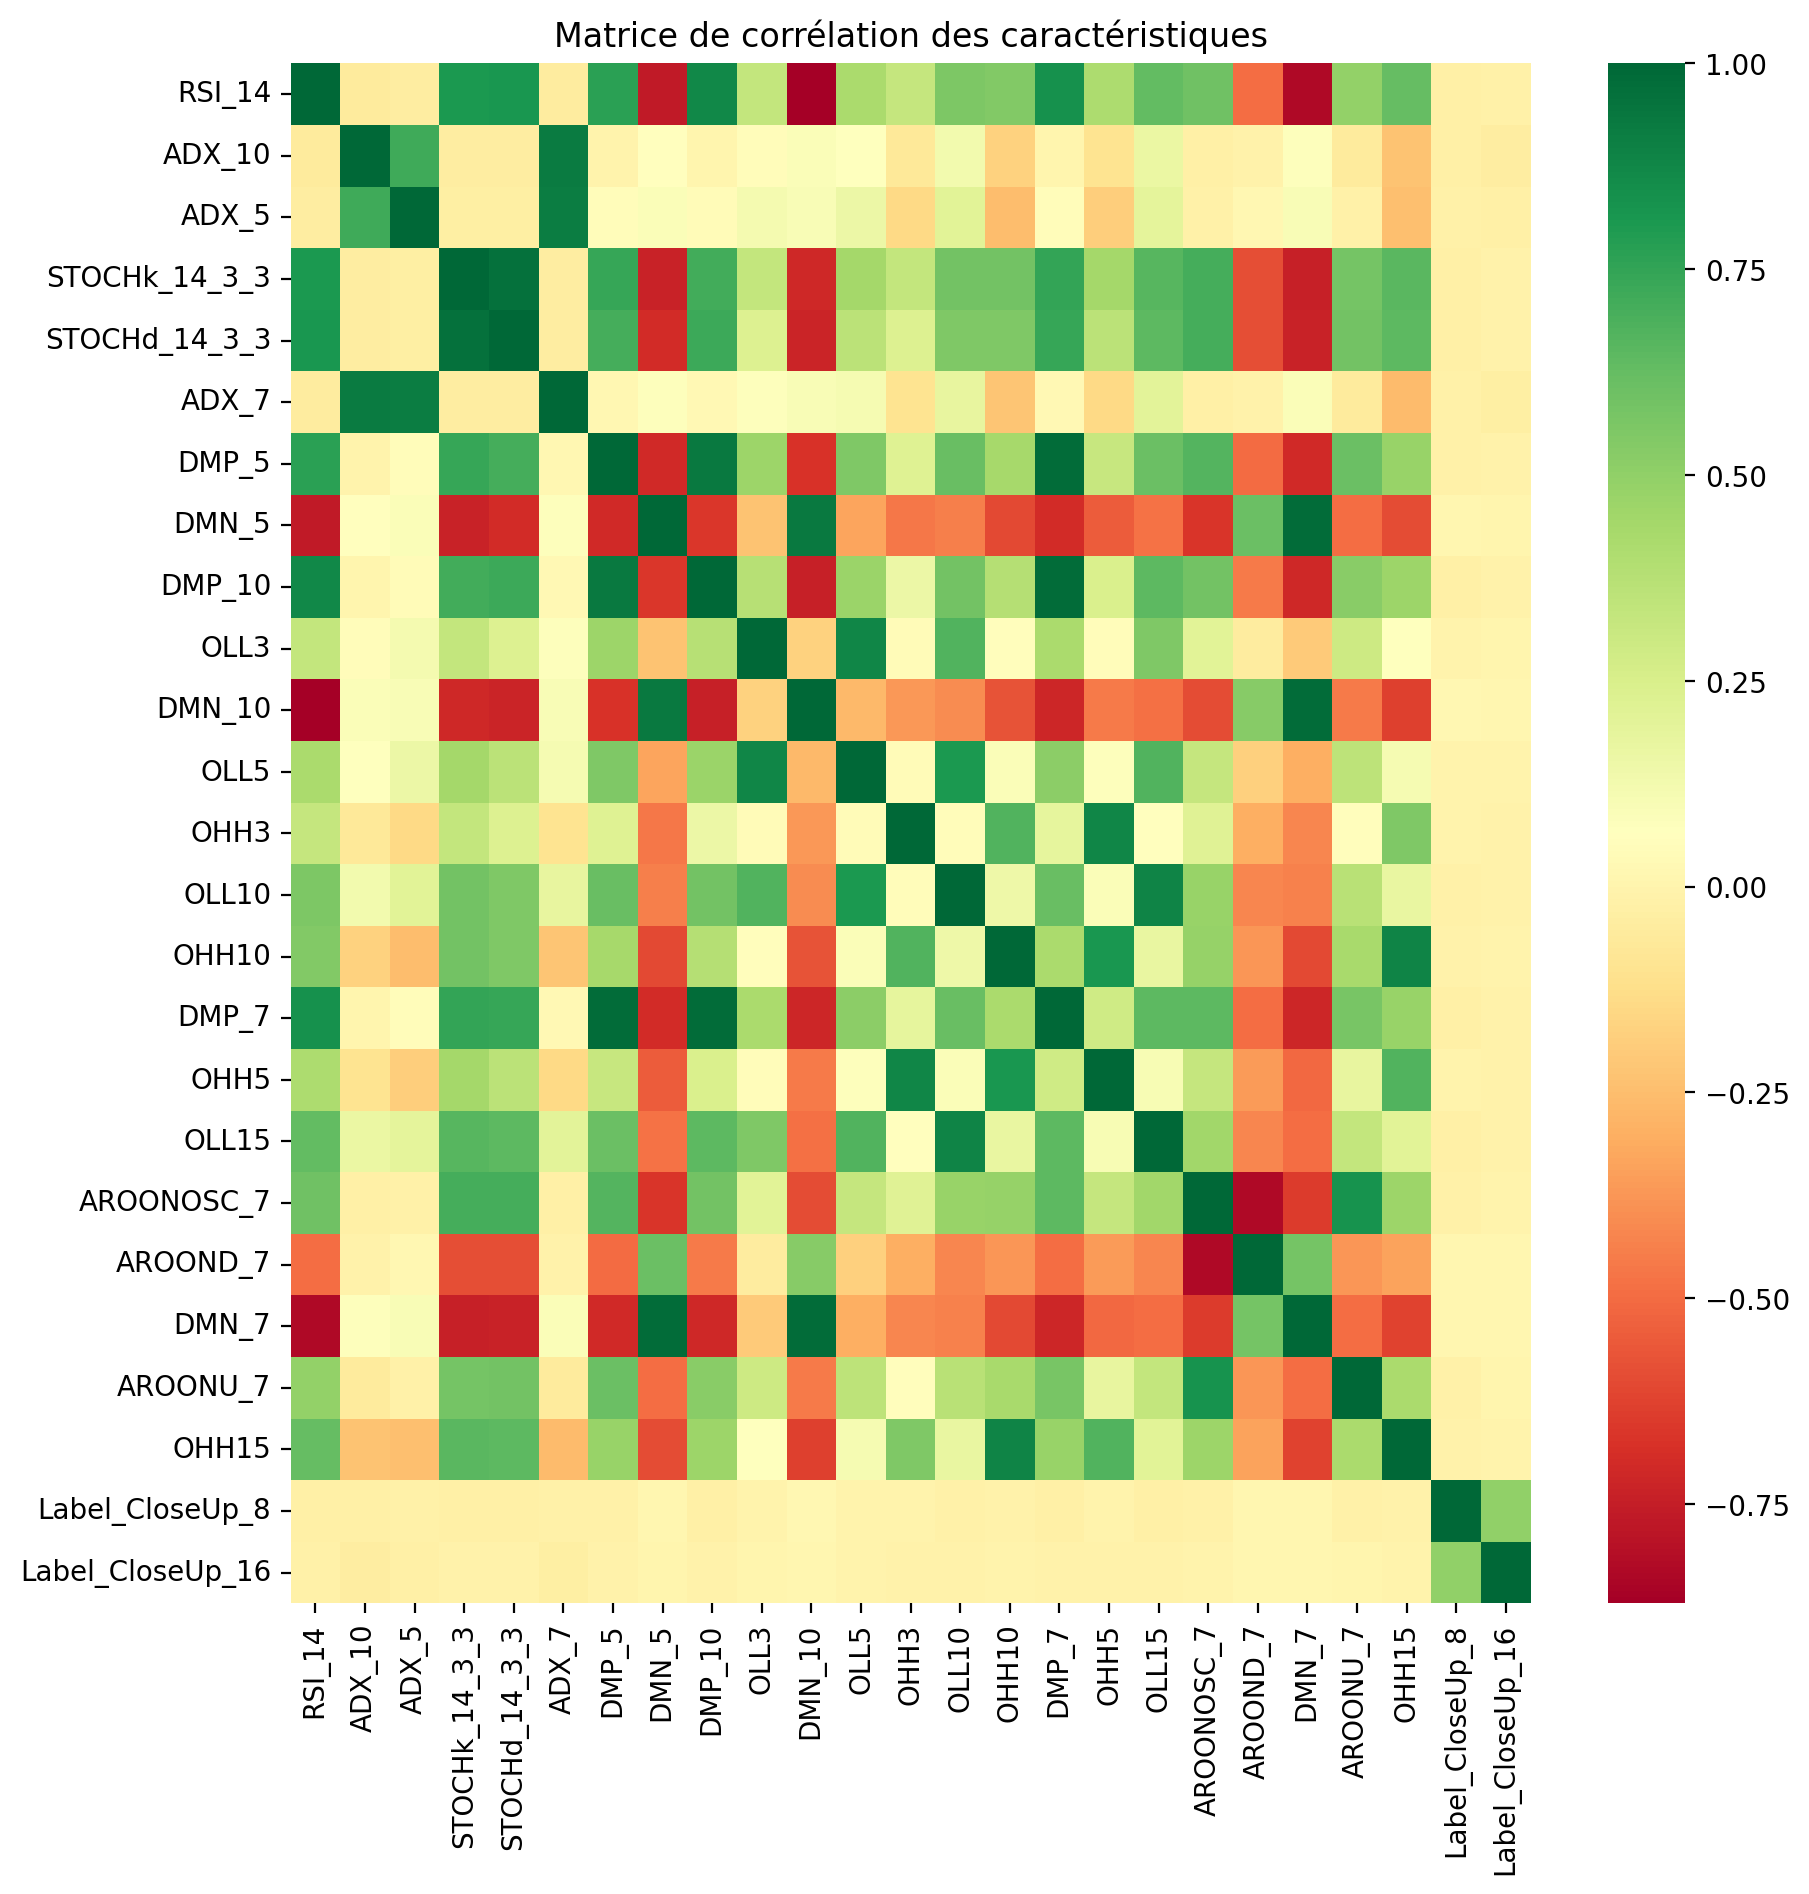

In [6]:
plt.figure(figsize=(10, 10))
# Features que l'on choisit de faire apparaître et variable cible
feat = [ 
    'RSI_14', 'ADX_10', 'ADX_5', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'ADX_7', 'DMP_5', 'DMN_5',
    'DMP_10', 'OLL3', 'DMN_10', 'OLL5', 'OHH3', 'OLL10', 'OHH10', 'DMP_7', 'OHH5', 'OLL15',
    'AROONOSC_7', 'AROOND_7', 'DMN_7',
    'AROONU_7', 'OHH15','Label_CloseUp_8','Label_CloseUp_16'
]



# Calcul de la matrice de corrélation
corr = df[feat].corr() 
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns,
            cmap='RdYlGn',
            annot=False)

plt.title('Matrice de corrélation des caractéristiques')
plt.show()

# Random Forest

In [8]:
# On introduit plusieurs jeux de paramètres différents, voici des exemples, pour limiter la dépendance à ces derniers
params = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
params1 = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

params2={
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 5
}
params3={
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features' : 0.3
}

# On initialise le modèle 
rf = RandomForestRegressor(**params3)

# On entraine le modèle
rf.fit(X_train, y_train)

# On obtient les importances
importances = rf.feature_importances_



# On affiche l'importance des caractéristiques
for i,(feature, importance) in enumerate(zip(features, importances)):
        print(f'("{feature}", {importance}),')


("open", 0.003688746626036105),
("high", 0.0046186401184828835),
("low", 0.004947511784786363),
("close", 0.004744155204633191),
("C1O1", 0.005890147261536794),
("C1O", 0.003001662432925743),
("C2O2", 0.0076843720991430385),
("C2O1", 0.0027761622639579714),
("C3O3", 0.006126670461298419),
("C3O2", 0.0028313936181458958),
("OH1", 0.006024728253094329),
("OL1", 0.004194851995910807),
("RSI_14", 0.03469821622193104),
("HH3", 0.003952615109510065),
("LL3", 0.004972890697101649),
("HH5", 0.004310927788131553),
("LL5", 0.003697122913359892),
("HH10", 0.00364469440378924),
("LL10", 0.003748136603215852),
("HH15", 0.003724803992427246),
("LL15", 0.004659182860999612),
("LL5LL3", 0.021590291235096322),
("LL10LL3", 0.02299394418356182),
("LL15LL3", 0.014979199854358626),
("HH5HH3", 0.0210303286261084),
("HH10HH3", 0.026679040987498636),
("HH15HH3", 0.027085059736347363),
("OLL3", 0.032673104994881456),
("OLL5", 0.03126816152262911),
("OLL10", 0.026003470127628096),
("OLL15", 0.025480631108249722

# PCA

In [11]:
# Mise à l'échelle des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_bck_scaled = scaler.transform(X_bck)

# Modèle PCA
pca = PCA(n_components= 10)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_bck_pca = pca.transform(X_bck_scaled)

# Composantes principales issues du PCA, dans components_df, chaque ligne représente une composante principale, et chaque colonne correspond à une des features originales.
components = pca.components_ 
components_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(len(components))])


# Calcul des charges factorielles absolues (mesurent l'importance de chaque feature dans chaque composante.)
absolute_loadings = np.abs(components)

# on somme les charges factorielles pour chaque feature à travers toutes les composantes. 
sum_loadings = np.sum(absolute_loadings, axis=0)

# Trier les caractéristiques selon leur importance
sorted_indices = np.argsort(sum_loadings)[::-1]

# Caractéristiques à garder
num_features_to_keep = 10  # Nombre de caractéristiques à garder
features_to_keep = [features[i] for i in sorted_indices[:num_features_to_keep]]

# Sélectionner uniquement les décompositions des 10 premières composantes principales pour les caractéristiques à garder
selected_components_df = components_df[features_to_keep]

# Affichage des décompositions des composantes principales sélectionnées
print(selected_components_df)
print("Caractéristiques à garder:", features_to_keep)

# Affichage de l'importance des caractéristiques sélectionnées
print("Importance des caractéristiques sélectionnées :")
for feature in features_to_keep:
    index = features.index(feature)
    print(f"{feature}: Importance = {sum_loadings[index]:.4f}")

      AROOND_7  AROONU_7    RSI_14  STOCHk_14_3_3  STOCHd_14_3_3     OHH15  \
PC1   0.069315 -0.082161  0.037121      -0.028152      -0.019775  0.021723   
PC2   0.239873 -0.092231 -0.238740      -0.343790      -0.338089 -0.194250   
PC3  -0.021428  0.131610  0.221877       0.055538       0.085450 -0.483621   
PC4   0.086926  0.063030 -0.282358      -0.177584      -0.267712 -0.078574   
PC5   0.341696 -0.437373  0.301420       0.161427       0.075933  0.109719   
PC6  -0.196960  0.038899 -0.152331      -0.137401      -0.227528 -0.093957   
PC7  -0.255727 -0.108193  0.237970       0.024673      -0.095781 -0.355569   
PC8   0.190863  0.353111  0.113381      -0.236592      -0.228913  0.114347   
PC9  -0.214853 -0.455620 -0.129729      -0.284848      -0.195009  0.119610   
PC10  0.257013  0.063742  0.062041      -0.259657      -0.170157 -0.124714   

          OLL3     OHH10  AROONOSC_7     ADX_5  
PC1   0.078208  0.048072   -0.052082  0.094515  
PC2  -0.095446 -0.150014   -0.241931 -0.057